# COVID-19 and Weather Patterns

## Imports

- *os* for interfacing with the operating system
- *pathlib* for interfacing with the file system
- *zipfile* for managing archive files

- *numpy* for array processing
- *pandas* for tabular processing
- *tensorflow* for tensor processing
- *keras* for simplified tensor processing

- *matplotlib* for visualization
- *seaborn* for enhanced visualization

In [1]:
# Custom
import data_processing

# File System
import os
import json
from pathlib import Path
from zipfile import ZipFile

# Memory
import gc

# Processing
import bisect
import numpy as np
import pandas as pd
from sympy import *
from sympy.geometry import *
import tensorflow
from tensorflow import keras

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

tensorflow.__version__

'2.7.0'

## Introduction

The goal of this work is to determine whether or not weather patterns should be considered as a meaningful supporting input when making predictions about new daily COVID-19 cases within a given geographical space. Using census, weather, and COVID-19 datasets provided by the Urban Sustain project, the authors attempt to quantify the correlation between particular weather patterns and COVID-19 transmission events.

## Defining Terms

***Urban Sustain Project*** - A joint effort between researchers at Colorado State University, Arizona State University, the University of California-Irvine, and the University of Maryland – Baltimore County.

## Loading Data

**DEVELOPER NOTE:** Download the five required datasets from Urban Sustain and place them in the cloned repository at ```./data/```. These datasets are also available at a shared OneDrive folder. This logic expects that these files exist at relative path ```../data/``` with respect to this notebook.

We'll begin by defining a path to our data directory and a list of the datasets that we expect to find there.

In [2]:
DATA_PATH = '../data/' # Point this constant to the location of your data archive files

EXPECTED_DATASETS = [
    'county_total_population.Colorado.zip',
    'covid_county.Colorado.zip',
    'neon_2d_wind.Colorado.zip',
    'neon_barometric_pressure.Colorado.zip',
    'neon_single_asp_air_temperature.Colorado.zip'
]

Next, we will attempt to extract each of these archived datasets into a dedicated subdirectory within the given data directory.

In [3]:
# For each listed dataset string in the EXPECTED_DATASETS constant
for datasetName in EXPECTED_DATASETS:
    try:
        # Open the given archive file
        with ZipFile(DATA_PATH + datasetName, 'r') as currentZip:
            # Build the target directory path for extracted data
            datasetNameTokens = datasetName.split('.')
            datasetNameTokens.remove('zip')
            targetDirectory = DATA_PATH + '.'.join(datasetNameTokens)
            
            # If the target directory doesn't exist, create it
            if not os.path.exists(targetDirectory):
                Path(targetDirectory).mkdir()
            
            # Extract all data from the archive file to the target directory
            currentZip.extractall(targetDirectory)
    except FileNotFoundError:
        print("Unable to open " + datasetName + " at path " + DATA_PATH + datasetName)

## File Information

Four of the five datasets referenced in this work relate geospatial information to particular events as they occur over time Each is provided by the Urban Sustain project and employs a similar file structure.

- data.json
- fieldLabels.json
- linkedGeometry.json
- README.txt


#### New York Times COVID-19 County Dataset

The included COVID-19 County dataset 

In [4]:
covidDataFrame = pd.io.json.read_json('../data/covid_county.Colorado/data.json')
covidDataFrame.sample(5)

,_id,GISJOIN,epoch_time,dateString,county,state,totalCaseCount,newCaseCount,totalDeathCount,newDeathCount
6214,{'$oid': '615fc624bf06594c4cad5a89'},G0800170,{'$numberLong': '1628056800000'},8/4/21,Cheyenne,Colorado,134,1,6,0
14690,{'$oid': '615fc625bf06594c4cad7cc5'},G0800450,{'$numberLong': '1630908000000'},9/6/21,Garfield,Colorado,6850,67,57,0
38074,{'$oid': '615fc628bf06594c4caddcc9'},G0801210,{'$numberLong': '1598162400000'},8/23/20,Washington,Colorado,52,0,0,0
16806,{'$oid': '615fc625bf06594c4cad8416'},G0800510,{'$numberLong': '1630821600000'},9/5/21,Gunnison,Colorado,1578,0,8,0
18076,{'$oid': '615fc626bf06594c4cad8806'},G0800550,{'$numberLong': '1610262000000'},1/10/21,Huerfano,Colorado,283,0,17,0


In [5]:
covidLabelsFrame = pd.io.json.read_json('../data/covid_county.Colorado/fieldLabels.json')
covidLabelsFrame.sample(5)

,name,label
4,totalCaseCount,Total Case Count
0,epoch_time,Date
3,newCaseCount,New Case Count
1,newDeathCount,New Death Count
2,totalDeathCount,Total Death Count


In [6]:
covidGeometryFrame = pd.io.json.read_json('../data/covid_county.Colorado/linkedGeometry.json')
covidGeometryFrame.sample(5)

,_id,type,geometry,properties,GISJOIN
54,{'$oid': '604964eefed2e95d6b68b9ce'},Feature,"{'type': 'Polygon', 'coordinates': [[[-106.857...","{'STATEFP10': '08', 'COUNTYFP10': '107', 'COUN...",G0801070
19,{'$oid': '604964ecfed2e95d6b68b56f'},Feature,"{'type': 'Polygon', 'coordinates': [[[-107.033...","{'STATEFP10': '08', 'COUNTYFP10': '037', 'COUN...",G0800370
5,{'$oid': '604964ecfed2e95d6b68b672'},Feature,"{'type': 'Polygon', 'coordinates': [[[-102.742...","{'STATEFP10': '08', 'COUNTYFP10': '011', 'COUN...",G0800110
0,{'$oid': '604964ecfed2e95d6b68b676'},Feature,"{'type': 'Polygon', 'coordinates': [[[-104.961...","{'STATEFP10': '08', 'COUNTYFP10': '001', 'COUN...",G0800010
16,{'$oid': '604964eefed2e95d6b68b9d0'},Feature,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...","{'STATEFP10': '08', 'COUNTYFP10': '031', 'COUN...",G0800310


#### NEON 2D Wind Dataset

In [7]:
windDataFrame = pd.io.json.read_json('../data/neon_2d_wind.Colorado/data.json')
windDataFrame.sample(5)

,_id,site,epoch_time,startDateTime,endDateTime,windSpeedMean,windSpeedMinimum,windSpeedMaximum,windSpeedVariance,windSpeedNumPts,windSpeedExpUncert,windSpeedStdErMean,windSpeedFinalQF,windDirMean,windDirVariance,windDirNumPts,windDirExpUncert,windDirStdErMean,windDirFinalQF
738121,{'$oid': '60cbc28551c1683b46636530'},RMNP_DP1.00001.001_000.010,{'$numberLong': '1505536200000'},2017-09-16T04:30:00Z,2017-09-16T05:00:00Z,1.25,0.00,4.10,0.48,1800,0.08,0.02,0,120.53,3180.12,1800,0.07,0.05,1
1036528,{'$oid': '60cbc28151c1683b4662e22c'},RMNP_DP1.00001.001_000.040,{'$numberLong': '1486018800000'},2017-02-02T07:00:00Z,2017-02-02T07:30:00Z,1.22,0.04,5.02,0.64,1800,0.10,0.02,0,164.03,7190.93,1800,0.07,0.04,1
694136,{'$oid': '60cbc70151c1683b46e04c98'},NIWO_DP1.00001.001_000.030,{'$numberLong': '1617847200000'},2021-04-08T02:00:00Z,2021-04-08T02:30:00Z,13.64,6.95,21.93,5.74,1800,1.20,0.06,0,293.65,61.91,1800,0.07,0.00,0
1083848,{'$oid': '60cbc29b51c1683b4665cac0'},RMNP_DP1.00001.001_000.040,{'$numberLong': '1577046600000'},2019-12-22T20:30:00Z,2019-12-22T21:00:00Z,1.61,0.01,6.78,1.31,1800,0.20,0.03,0,215.22,7537.31,1800,0.07,0.04,1
878338,{'$oid': '60cbc29d51c1683b4665f9dc'},RMNP_DP1.00001.001_000.020,{'$numberLong': '1585362600000'},2020-03-28T02:30:00Z,2020-03-28T03:00:00Z,0.24,0.00,0.56,0.01,1796,0.02,0.00,0,103.32,2741.17,1796,0.07,0.03,1


In [8]:
windLabelsFrame = pd.io.json.read_json('../data/neon_2d_wind.Colorado/fieldLabels.json')
windLabelsFrame.sample(5)

,name,label
37,windDirStdErMean,Standard error of the mean for wind direction
55,windDirValidCalNAQM,Wind direction quality metric that summarizes ...
59,windDirFinalQF,Wind direction quality flag indicating whether...
15,windSpeedPersistenceNAQM,Wind speed quality metric that summarizes when...
14,windSpeedPersistencePassQM,Wind speed quality metric that summarizes the ...


In [9]:
windGeometryFrame = pd.io.json.read_json('../data/neon_2d_wind.Colorado/linkedGeometry.json')
windGeometryFrame.sample(5)

,_id,type,geometry,properties,site
3,{'$oid': '60cbcf5eed5577c25c205232'},Feature,"{'type': 'Point', 'coordinates': [-105.545955,...","{'HOR.VER': '000.030', 'name': 'CFGLOC100672',...",RMNP_DP1.00001.001_000.030
5,{'$oid': '60cbcf5eed5577c25c205294'},Feature,"{'type': 'Point', 'coordinates': [-105.58238, ...","{'HOR.VER': '000.010', 'name': 'CFGLOC109345',...",NIWO_DP1.00001.001_000.010
2,{'$oid': '60cbcf5eed5577c25c205231'},Feature,"{'type': 'Point', 'coordinates': [-105.545955,...","{'HOR.VER': '000.020', 'name': 'CFGLOC100669',...",RMNP_DP1.00001.001_000.020
12,{'$oid': '60cbcf5eed5577c25c205209'},Feature,"{'type': 'Point', 'coordinates': [-103.02929, ...","{'HOR.VER': '000.020', 'name': 'CFGLOC100114',...",STER_DP1.00001.001_000.020
0,{'$oid': '60cbcf5eed5577c25c205230'},Feature,"{'type': 'Point', 'coordinates': [-105.545955,...","{'HOR.VER': '000.010', 'name': 'CFGLOC100666',...",RMNP_DP1.00001.001_000.010


#### NEON Barometric Pressure Dataset

In [10]:
pressureDataFrame = pd.io.json.read_json('../data/neon_barometric_pressure.Colorado/data.json')
pressureDataFrame.sample(5)

,_id,site,epoch_time,startDateTime,endDateTime,staPresMean,staPresMinimum,staPresMaximum,staPresVariance,staPresNumPts,staPresExpUncert,staPresStdErMean,staPresFinalQF,corPres,corPresExpUncert,corPresFinalQF
389977,{'$oid': '60c78cd9c8cb4f3f3b21e583'},STER_DP1.00004.001,{'$numberLong': '1441110600000'},2015-09-01T12:30:00Z,2015-09-01T13:00:00Z,86.31248,86.29155,86.32355,0.00008,180,0.01725,0.00066,0,101.17074,0.10690,0
325612,{'$oid': '60c78c9bc8cb4f3f3b1abc26'},RMNP_DP1.00004.001,{'$numberLong': '1507806000000'},2017-10-12T11:00:00Z,2017-10-12T11:30:00Z,70.84638,70.82128,70.86966,0.00013,180,0.01728,0.00085,1,97.91936,0.39273,1
390946,{'$oid': '60c78cd9c8cb4f3f3b21ea99'},STER_DP1.00004.001,{'$numberLong': '1443461400000'},2015-09-28T17:30:00Z,2015-09-28T18:00:00Z,86.27857,86.27054,86.28654,0.00001,178,0.01721,0.00027,0,100.83653,0.10326,0
308337,{'$oid': '60c78c99c8cb4f3f3b1a78e4'},RMNP_DP1.00004.001,{'$numberLong': '1474975800000'},2016-09-27T11:30:00Z,2016-09-27T12:00:00Z,73.70733,73.69749,73.70749,0.00000,180,0.01720,0.00010,0,102.71883,0.43317,0
280528,{'$oid': '60c78c2ec8cb4f3f3b0e2034'},NIWO_DP1.00004.001,{'$numberLong': '1587821400000'},2020-04-25T13:30:00Z,2020-04-25T14:00:00Z,66.66028,66.64912,66.66911,0.00006,180,0.04731,0.00057,0,101.79534,0.70736,0


In [11]:
pressureLabelsFrame = pd.io.json.read_json('../data/neon_barometric_pressure.Colorado/fieldLabels.json')
pressureLabelsFrame.sample(5)

,name,label
23,staPresGapPassQM,Station pressure quality metric that summarize...
31,staPresAlphaQM,Station pressure quality metric detailing the ...
30,staPresValidCalNAQM,Station pressure quality metric that summarize...
11,staPresRangePassQM,Station pressure quality metric that summarize...
35,corPres,Mean station pressure corrected to sea level


In [12]:
pressureGeometryFrame = pd.io.json.read_json('../data/neon_barometric_pressure.Colorado/linkedGeometry.json')
pressureGeometryFrame.sample(5)

,_id,type,geometry,properties,site
2,{'$oid': '60c78a9d230c7f49850c20b0'},Feature,"{'type': 'Point', 'coordinates': [-105.544602,...","{'site': 'COMO_DP1.00004.001', 'name': 'neon_b...",COMO_DP1.00004.001
3,{'$oid': '60c78a9d230c7f49850c20cf'},Feature,"{'type': 'Point', 'coordinates': [-105.58238, ...","{'site': 'NIWO_DP1.00004.001', 'name': 'neon_b...",NIWO_DP1.00004.001
6,{'$oid': '60c78a9d230c7f49850c20a5'},Feature,"{'type': 'Point', 'coordinates': [-102.450966,...","{'site': 'ARIK_DP1.00004.001', 'name': 'neon_b...",ARIK_DP1.00004.001
4,{'$oid': '60c78a9d230c7f49850c20b1'},Feature,"{'type': 'Point', 'coordinates': [-104.74559, ...","{'site': 'CPER_DP1.00004.001', 'name': 'neon_b...",CPER_DP1.00004.001
1,{'$oid': '60c78a9d230c7f49850c20ef'},Feature,"{'type': 'Point', 'coordinates': [-105.914674,...","{'site': 'WLOU_DP1.00004.001', 'name': 'neon_b...",WLOU_DP1.00004.001


#### NEON Air Temperature

In [13]:
temperatureDataFrame = pd.io.json.read_json('../data/neon_single_asp_air_temperature.Colorado/data.json')
temperatureDataFrame.sample(5)

,_id,site,epoch_time,startDateTime,endDateTime,tempSingleMean,tempSingleMinimum,tempSingleMaximum,tempSingleVariance,tempSingleNumPts,tempSingleExpUncert,tempSingleStdErMean,finalQF
264960,{'$oid': '60cbd3c50fc3818c81de6407'},CPER_DP1.00002.001_000.020,{'$numberLong': '1463346000000'},2016-05-15T21:00:00Z,2016-05-15T21:30:00Z,10.2260,9.9096,11.1430,0.0620,1800,0.1394,0.0059,0
217721,{'$oid': '60cbd3d70fc3818c81e0812d'},CPER_DP1.00002.001_000.010,{'$numberLong': '1580218200000'},2020-01-28T13:30:00Z,2020-01-28T14:00:00Z,-2.6345,-3.2807,-2.3043,0.0583,1800,0.1334,0.0057,0
423084,{'$oid': '60cbd3da0fc3818c81e0f0bf'},CPER_DP1.00002.001_000.030,{'$numberLong': '1595275200000'},2020-07-20T20:00:00Z,2020-07-20T20:30:00Z,27.4709,27.1084,28.4722,0.0627,1800,0.1467,0.0059,0
798587,{'$oid': '60cbd5210fc3818c81080799'},RMNP_DP1.00002.001_000.030,{'$numberLong': '1469057400000'},2016-07-20T23:30:00Z,2016-07-21T00:00:00Z,17.9461,17.7985,18.1237,0.0067,1800,0.1421,0.0019,0
212952,{'$oid': '60cbd3d50fc3818c81e04f2e'},CPER_DP1.00002.001_000.010,{'$numberLong': '1571868000000'},2019-10-23T22:00:00Z,2019-10-23T22:30:00Z,4.6284,3.7804,5.3605,0.1269,1800,0.1375,0.0084,0


In [14]:
temperatureLabelsFrame = pd.io.json.read_json('../data/neon_single_asp_air_temperature.Colorado/fieldLabels.json')
temperatureLabelsFrame.sample(5)

,name,label
23,gapPassQM,Quality metric that summarizes the passed outc...
25,spikeFailQM,Quality metric that summarizes the failed outc...
32,heaterPassQM,Quality metric that summarizes when the heater...
38,betaQM,Quality metric detailing the outcomes of the b...
8,tempSingleExpUncert,Expanded uncertainty for single aspirated air ...


In [15]:
temperatureGeometryFrame = pd.io.json.read_json('../data/neon_single_asp_air_temperature.Colorado/linkedGeometry.json')
temperatureGeometryFrame.sample(5)

,_id,type,geometry,properties,site
7,{'$oid': '60cbd3907adbc5ff35cc422d'},Feature,"{'type': 'Point', 'coordinates': [-105.58238, ...","{'HOR.VER': '000.010', 'name': 'CFGLOC109344',...",NIWO_DP1.00002.001_000.010
13,{'$oid': '60cbd3907adbc5ff35cc41a3'},Feature,"{'type': 'Point', 'coordinates': [-103.02929, ...","{'HOR.VER': '000.030', 'name': 'CFGLOC100018',...",STER_DP1.00002.001_000.030
6,{'$oid': '60cbd3907adbc5ff35cc422f'},Feature,"{'type': 'Point', 'coordinates': [-105.58238, ...","{'HOR.VER': '000.030', 'name': 'CFGLOC109358',...",NIWO_DP1.00002.001_000.030
3,{'$oid': '60cbd3907adbc5ff35cc41c9'},Feature,"{'type': 'Point', 'coordinates': [-105.545955,...","{'HOR.VER': '000.010', 'name': 'CFGLOC100665',...",RMNP_DP1.00002.001_000.010
2,{'$oid': '60cbd3907adbc5ff35cc41cc'},Feature,"{'type': 'Point', 'coordinates': [-105.545955,...","{'HOR.VER': '000.040', 'name': 'CFGLOC100674',...",RMNP_DP1.00002.001_000.040


### U.S. Census Total County Population Dataset

In [16]:
populationDataFrame = pd.io.json.read_json('../data/county_total_population.Colorado/data.json')
populationDataFrame

,_id,GISJOIN,STATE,STATEFP,STATENH,COUNTY,COUNTYFP,COUNTYNH,1980_total_population,1990_total_population,2000_total_population,2010_total_population
0,{'$oid': '607d4c2708e81eceb6b6e384'},G0800010,Colorado,8,80,Adams County,1,10,245944,265038,363857,441603
1,{'$oid': '607d4c2708e81eceb6b6e385'},G0800030,Colorado,8,80,Alamosa County,3,30,11799,13617,14966,15445
2,{'$oid': '607d4c2708e81eceb6b6e386'},G0800050,Colorado,8,80,Arapahoe County,5,50,293621,391511,487967,572003
3,{'$oid': '607d4c2708e81eceb6b6e387'},G0800070,Colorado,8,80,Archuleta County,7,70,3664,5345,9898,12084
4,{'$oid': '607d4c2708e81eceb6b6e388'},G0800090,Colorado,8,80,Baca County,9,90,5419,4556,4517,3788
...,...,...,...,...,...,...,...,...,...,...,...,...
58,{'$oid': '607d4c2708e81eceb6b6e3bf'},G0801170,Colorado,8,80,Summit County,117,1170,8848,12881,23548,27994
59,{'$oid': '607d4c2708e81eceb6b6e3c4'},G0801190,Colorado,8,80,Teller County,119,1190,8034,12468,20555,23350
60,{'$oid': '607d4c2708e81eceb6b6e3c3'},G0801210,Colorado,8,80,Washington County,121,1210,5304,4812,4926,4814
61,{'$oid': '607d4c2708e81eceb6b6e3c2'},G0801230,Colorado,8,80,Weld County,123,1230,123438,131821,180936,252825


In [17]:
populationLabelsFrame = pd.io.json.read_json('../data/county_total_population.Colorado/fieldLabels.json')
populationLabelsFrame

""


In [18]:
populationGeometryFrame = pd.io.json.read_json('../data/county_total_population.Colorado/linkedGeometry.json')
populationGeometryFrame

,_id,type,geometry,properties,GISJOIN
0,{'$oid': '604964ecfed2e95d6b68b676'},Feature,"{'type': 'Polygon', 'coordinates': [[[-104.961...","{'STATEFP10': '08', 'COUNTYFP10': '001', 'COUN...",G0800010
1,{'$oid': '604964ecfed2e95d6b68b684'},Feature,"{'type': 'Polygon', 'coordinates': [[[-105.457...","{'STATEFP10': '08', 'COUNTYFP10': '003', 'COUN...",G0800030
2,{'$oid': '604964eefed2e95d6b68bb16'},Feature,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...","{'STATEFP10': '08', 'COUNTYFP10': '005', 'COUN...",G0800050
3,{'$oid': '604964eefed2e95d6b68b9c8'},Feature,"{'type': 'Polygon', 'coordinates': [[[-107.128...","{'STATEFP10': '08', 'COUNTYFP10': '007', 'COUN...",G0800070
4,{'$oid': '604964eefed2e95d6b68b83d'},Feature,"{'type': 'Polygon', 'coordinates': [[[-102.747...","{'STATEFP10': '08', 'COUNTYFP10': '009', 'COUN...",G0800090
...,...,...,...,...,...
59,{'$oid': '604964ecfed2e95d6b68b677'},Feature,"{'type': 'Polygon', 'coordinates': [[[-105.924...","{'STATEFP10': '08', 'COUNTYFP10': '117', 'COUN...",G0801170
60,{'$oid': '604964eefed2e95d6b68b840'},Feature,"{'type': 'Polygon', 'coordinates': [[[-105.329...","{'STATEFP10': '08', 'COUNTYFP10': '119', 'COUN...",G0801190
61,{'$oid': '604964eefed2e95d6b68b9c5'},Feature,"{'type': 'Polygon', 'coordinates': [[[-102.779...","{'STATEFP10': '08', 'COUNTYFP10': '121', 'COUN...",G0801210
62,{'$oid': '604964eefed2e95d6b68b9c3'},Feature,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...","{'STATEFP10': '08', 'COUNTYFP10': '123', 'COUN...",G0801230


## Data Exploration

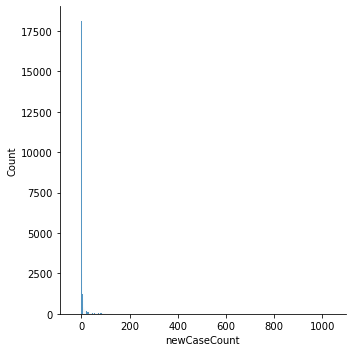

In [19]:
sns.displot(covidDataFrame.newCaseCount)

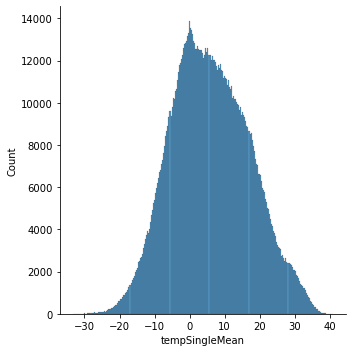

In [20]:
sns.displot(temperatureDataFrame.tempSingleMean)

#### Garbage Collect

In [21]:
del covidDataFrame
del covidLabelsFrame
del covidGeometryFrame

del windDataFrame
del windLabelsFrame
del windGeometryFrame

del pressureDataFrame
del pressureLabelsFrame
del pressureGeometryFrame

del temperatureDataFrame
del temperatureLabelsFrame
del temperatureGeometryFrame

del populationDataFrame
del populationLabelsFrame
del populationGeometryFrame

gc.collect()

69

## Preprocessing

#### Flatten Frames

In [22]:
flattenedCovidDataFrame = pd.json_normalize(json.load(open(Path('../data/covid_county.Colorado/data.json'))))
flattenedCovidGeometryFrame = pd.json_normalize(json.load(open(Path('../data/covid_county.Colorado/linkedGeometry.json'))))

flattenedWindDataFrame = pd.json_normalize(json.load(open(Path('../data/neon_2d_wind.Colorado/data.json'))))
flattenedWindGeometryFrame = pd.json_normalize(json.load(open(Path('../data/neon_2d_wind.Colorado/linkedGeometry.json'))))

flattenedPressureDataFrame = pd.json_normalize(json.load(open(Path('../data/neon_barometric_pressure.Colorado/data.json'))))
flattenedPressureGeometryFrame = pd.json_normalize(json.load(open(Path('../data/neon_barometric_pressure.Colorado/linkedGeometry.json'))))

flattenedTemperatureDataFrame = pd.json_normalize(json.load(open(Path('../data/neon_single_asp_air_temperature.Colorado/data.json'))))
flattenedTemperatureGeometryFrame = pd.json_normalize(json.load(open(Path('../data/neon_single_asp_air_temperature.Colorado/linkedGeometry.json'))))

flattenedPopulationDataFrame = pd.json_normalize(json.load(open(Path('../data/county_total_population.Colorado/data.json'))))
flattenedPopulationGeometryFrame = pd.json_normalize(json.load(open(Path('../data/county_total_population.Colorado/linkedGeometry.json'))))

#### Join Data and Geometry

In [23]:
combinedCovidFrame = flattenedCovidDataFrame.set_index('GISJOIN').join(flattenedCovidGeometryFrame.set_index('GISJOIN'), lsuffix='_data', rsuffix='_geo')
combinedWindFrame = flattenedWindDataFrame.set_index('site').join(flattenedWindGeometryFrame.set_index('site'), lsuffix='_data', rsuffix='_geo')
combinedPressureFrame = flattenedPressureDataFrame.set_index('site').join(flattenedPressureGeometryFrame.set_index('site'), lsuffix='_data', rsuffix='_geo')
combinedTemperatureFrame = flattenedTemperatureDataFrame.set_index('site').join(flattenedTemperatureGeometryFrame.set_index('site'), lsuffix='_data', rsuffix='_geo')
combinedPopulationFrame = flattenedPopulationDataFrame.set_index('GISJOIN').join(flattenedPopulationGeometryFrame.set_index('GISJOIN'), lsuffix='_data', rsuffix='_geo')

In [24]:
del flattenedCovidDataFrame
del flattenedCovidGeometryFrame

del flattenedWindDataFrame
del flattenedWindGeometryFrame

del flattenedPressureDataFrame
del flattenedPressureGeometryFrame

del flattenedTemperatureDataFrame
del flattenedTemperatureGeometryFrame

del flattenedPopulationDataFrame
del flattenedPopulationGeometryFrame

gc.collect()

20

#### Generalize Geometry

In [25]:
def create_county_polygons(combinedCovidFrame):
    county_polygons = []
    df = combinedCovidFrame.groupby('county').first().reindex(columns=['coordJsonString', 'geometry.type', "geometry.coordinates"])
    print(df)
    df['coordJsonString'] = df["geometry.coordinates"].apply(json.dumps)
    for index, row in df[['coordJsonString', 'geometry.type']].iterrows():
        print(f"processing: {index}")
        shape_data = json.loads(row['coordJsonString'])
        county = index
        if row['geometry.type'] == 'MultiPolygon':
            for p in shape_data:
                s = np.asarray(p)[0]
                shape = Polygon(*s)
                county_polygons.append((county, shape))
        elif row['geometry.type'] == 'Polygon':
            s = np.asarray(shape_data)[0]
            shape = Polygon(*s)
            county_polygons.append((county, shape))
        else:
            print(f"Row had geometry type of {row['geometry.type']}, row is {row}")
    return county_polygons
#
county_polygons = create_county_polygons(combinedCovidFrame)

            coordJsonString geometry.type  \
county                                      
Adams                   NaN       Polygon   
Alamosa                 NaN       Polygon   
Arapahoe                NaN  MultiPolygon   
Archuleta               NaN       Polygon   
Baca                    NaN       Polygon   
...                     ...           ...   
Summit                  NaN       Polygon   
Teller                  NaN       Polygon   
Washington              NaN       Polygon   
Weld                    NaN  MultiPolygon   
Yuma                    NaN       Polygon   

                                         geometry.coordinates  
county                                                         
Adams       [[[-104.96140800028297, 40.00033699940714], [-...  
Alamosa     [[[-105.45725500006058, 37.75146400032936], [-...  
Arapahoe    [[[[-104.93042900099888, 39.66755700030373], [...  
Archuleta   [[[-107.1286799987523, 37.42294200083849], [-1...  
Baca        [[[-102.7476149999

In [33]:
# For O(1) retrieval operation time complexity
polygonCountyMap = {}
countyPolygonMap = {}
countyAvailabilityMap ={}

# For O(log n) search operation time complexity
xSortedCountyPolygons = []
ySortedCountyPolygons = []
countyAvailabilityList = []

for entry in county_polygons:
    county = entry[0]
    polygon = entry[1]
    
    polygonCountyMap[polygon] = county
    countyPolygonMap[county] = polygon
    
    if not county in countyAvailabilityMap:
        countyAvailabilityList.append(county)
    countyAvailabilityMap[county] = True
    
    xSortedCountyPolygons.append((county, countyPolygonMap[county].centroid))
    ySortedCountyPolygons.append((county, countyPolygonMap[county].centroid))
    
xSortedCountyPolygons.sort(key=lambda x:x[1][0])
ySortedCountyPolygons.sort(key=lambda x:x[1][1])

print(county_polygons[0][0])
print(polygonCountyMap[county_polygons[0][1]])

print()
for entry in xSortedCountyPolygons:
    print(N(entry[1][0], 5))
    
print()
for entry in ySortedCountyPolygons:
    print(N(entry[1][1], 5))

Adams
Adams

-108.60
-108.52
-108.47
-108.41
-108.27
-108.22
-108.21
-107.90
-107.86
-107.84
-107.77
-107.68
-107.30
-107.05
-107.03
-106.99
-106.92
-106.92
-106.70
-106.38
-106.34
-106.34
-106.28
-106.19
-106.19
-106.12
-106.12
-105.79
-105.72
-105.64
-105.52
-105.46
-105.44
-105.43
-105.37
-105.36
-105.25
-105.16
-105.10
-105.06
-105.06
-105.05
-105.05
-104.98
-104.96
-104.94
-104.93
-104.93
-104.93
-104.92
-104.91
-104.90
-104.88
-104.53
-104.51
-104.39
-104.34
-104.34
-104.14
-104.04
-103.81
-103.78
-103.72
-103.51
-103.20
-103.11
-103.07
-102.74
-102.60
-102.60
-102.56
-102.42
-102.39
-102.36
-102.35

37.194
37.201
37.278
37.287
37.316
37.319
37.338
37.573
37.583
37.669
37.685
37.752
37.764
37.821
37.903
37.955
37.955
38.004
38.081
38.109
38.156
38.173
38.327
38.402
38.433
38.473
38.667
38.747
38.828
38.832
38.861
38.882
38.988
39.018
39.119
39.202
39.217
39.287
39.305
39.330
39.586
39.599
39.626
39.628
39.634
39.635
39.650
39.667
39.671
39.681
39.685
39.689
39.699
39.704
39.761
3

In [47]:
def append_counties_to_frame(frame):
    frame['county'] = np.nan
    for index, row in frame.sample(1).iterrows():
        point = Point(np.asarray(row['geometry.coordinates']))

        availabilityMap = countyAvailabilityMap.copy()
        availabilityList = countyAvailabilityList.copy()

        xKeys = [N(r[1][0]) for r in xSortedCountyPolygons]
        yKeys = [N(r[1][1]) for r in ySortedCountyPolygons]

        xIndex = bisect.bisect_left(xKeys, N(point[0]))
        yIndex = bisect.bisect_left(yKeys, N(point[1]))

        axisToggle = True
        xLeftRightToggle = True
        yLeftRightToggle = True
        currentLeftX = xIndex
        currentRightX = xIndex
        currentYLeft = yIndex
        currentYRight = yIndex
        attempts = 1
        while availabilityList:
            # Toggle heuristic search between X and Y axis
            if axisToggle:
                test = None
                if xLeftRightToggle:
                    test = xSortedCountyPolygons[currentRightX]
                else:
                    test = xSortedCountyPolygons[currentLeftX]

                county = test[0]
                centroid = test[1]

                if availabilityMap[county]:
                    shape = countyPolygonMap[county]

                    # Check if county shape includes this location
                    if shape.encloses_point(point):
                        frame.at[index, 'county'] = county
                        print('County: ' + county)
                        break

                    attempts = attempts + 1
                    availabilityMap[county] = False
                    availabilityList.remove(county)

                if xLeftRightToggle:
                    currentRightX = currentRightX + 1
                    if currentRightX >= len(xSortedCountyPolygons):
                        currentRightX = 0
                    xLeftRightToggle = False
                else:
                    currentLeftX = currentLeftX - 1
                    if currentLeftX < 0:
                        currentLeftX = len(xSortedCountyPolygons) - 1
                    xLeftRightToggle = True
                    
                toggle = False
            else:
                test = None
                if xLeftRightToggle:
                    test = ySortedCountyPolygons[currentRightY]
                else:
                    test = ySortedCountyPolygons[currentLeftY]
                    
                county = test[0]
                centroid = test[1]

                if availabilityMap[county]:
                    shape = countyPolygonMap[county]

                    # Check if county shape includes this location
                    if shape.encloses_point(point):
                        frame.at[index, 'county'] = county
                        print('County: ' + county)
                        break

                    attempts = attempts + 1
                    availabilityMap[county] = False
                    availabilityList.remove(county)

                if yLeftRightToggle:
                    currentRightY = currentRightY + 1
                    if currentRightY >= len(ySortedCountyPolygons):
                        currentRightY = 0
                    yLeftRightToggle = False
                else:
                    currentLeftY = currentLeftY - 1
                    if currentLeftY < 0:
                        currentLeftY = len(ySortedCountyPolygons) - 1
                    yLeftRightToggle = True
                    
                toggle = True

        print('Attempts: ' + str(attempts))
        print()

In [48]:
append_counties_to_frame(combinedWindFrame)
append_counties_to_frame(combinedPressureFrame)
append_counties_to_frame(combinedTemperatureFrame)

County: Boulder
Attempts: 10

County: Logan
Attempts: 5

County: Logan
Attempts: 5



In [49]:
combinedCovidFrame.to_csv('../data/combined_covid_frame.csv')
combinedWindFrame.to_csv('../data/combined_wind_frame.csv')
combinedPressureFrame.to_csv('../data/combined_pressure_frame.csv')
combinedTemperatureFrame.to_csv('../data/combined_temperature_frame.csv')
combinedPopulationFrame.to_csv('../data/combined_population_frame.csv')

## References

## About this Notebook

**Authors:** Kyle Bassignani, Jeff Borgerson, and Christian Westbrook  
**Updated On:** 2021-11-20